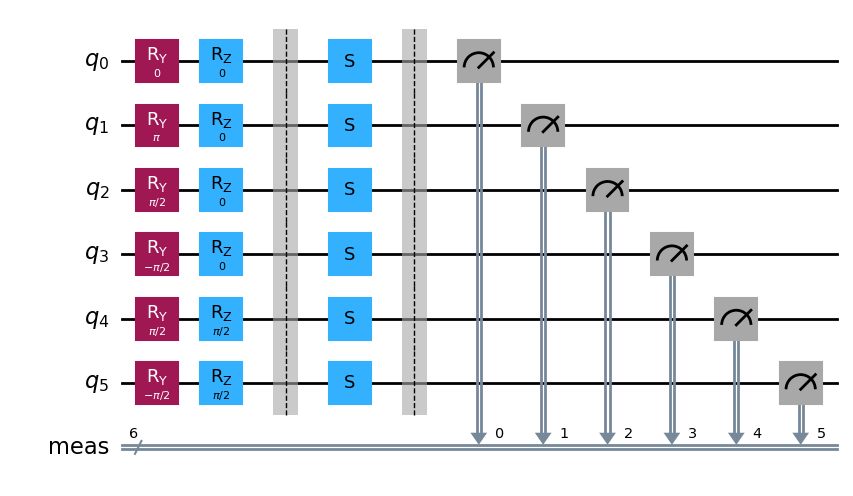

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.visualization import circuit_drawer
import numpy as np

# Define the reference states initialization
def initialize_reference_states(qc):
    # |0⟩ state on qubit 0
    qc.ry(0, 0)
    qc.rz(0, 0)

    # |1⟩ state on qubit 1
    qc.ry(np.pi, 1)
    qc.rz(0, 1)

    # |+⟩ state on qubit 2
    qc.ry(np.pi/2, 2)
    qc.rz(0, 2)

    # |−⟩ state on qubit 3
    qc.ry(-np.pi/2, 3)
    qc.rz(0, 3)

    # |+i⟩ state on qubit 4
    qc.ry(np.pi/2, 4)
    qc.rz(np.pi/2, 4)

    # |-i⟩ state on qubit 5
    qc.ry(-np.pi/2, 5)
    qc.rz(np.pi/2, 5)


# Create a 6-qubit quantum circuit
circuit = QuantumCircuit(6)

# Initialize the reference states
initialize_reference_states(circuit)

# Apply the same unitary to all 6 qubits
circuit.barrier()  # Add a barrier for clarity in the visualization
for qubit in range(6):
    circuit.s(qubit)

# Draw the circuit
circuit.measure_all()
circuit_drawer(circuit, output='mpl')


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Define the reference circuits for each state
def create_reference_circuits_s():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Pauli-Z variational circuit
variational_circuit_s = QuantumCircuit(1)
variational_circuit_s.s(0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit_s, variational_circuit_s):
    combined_circuit_s = reference_circuit_s.compose(variational_circuit_s, inplace=False)
    return combined_circuit_s

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Function to produce measurements and put them in a matrix
def produce_measurements_pauli_s():
    measurements_matrix_s = []

    reference_circuits_s = create_reference_circuits_s()

    # Iterate over the reference circuits
    for reference_circuit_s in reference_circuits_s:
        # Combine the reference circuit with the Pauli-X gate circuit
        combined_circuit_s = combine_circuits(reference_circuit_s, variational_circuit_s)
        
        # Measure the combined circuit in each basis
        prob_z = get_probabilities(measure_circuit(combined_circuit_s.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(combined_circuit_s.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(combined_circuit_s.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append measurements for the current reference circuit
        measurements_matrix_s.append(measured_probabilities)

    return np.array(measurements_matrix_s)

# Produce and print measurements for the Pauli-X circuit
measurements_matrix_s = produce_measurements_pauli_s()
print("Measurements matrix for Pauli-Z gate:")
print(measurements_matrix_s)


Measurements matrix for Pauli-Z gate:
[[1.         0.         0.49414062 0.50585938 0.5        0.5       ]
 [0.         1.         0.50195312 0.49804688 0.51367188 0.48632812]
 [0.52929688 0.47070312 0.48046875 0.51953125 1.         0.        ]
 [0.50488281 0.49511719 0.51171875 0.48828125 0.         1.        ]
 [0.50488281 0.49511719 0.         1.         0.484375   0.515625  ]
 [0.46191406 0.53808594 1.         0.         0.50683594 0.49316406]]


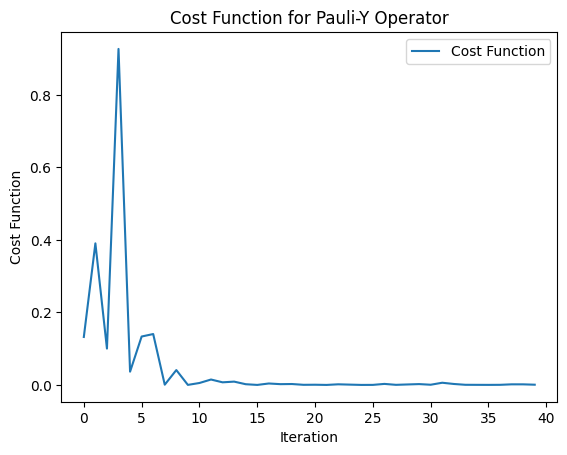

Optimal Parameters: [0.12753825 0.78539816 0.78326673]
Optimal Cost: 0.0006275177001953125


Optimal Parameters:
theta: 0.12753825054607282
phi: 0.7853981633974484
Lambda:0.7832667285880712


In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a variational circuit
variational_circuit = QuantumCircuit(1)
variational_circuit.rz(Lambda, 0)
variational_circuit.ry(theta, 0)
variational_circuit.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost


# Callback function to stop optimization if the cost function is less than 0.003
def stopping_callback(params):
    cost = cost_function(params, target_measurements_S)  # Recalculate the cost function

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0] 

def constraint_theta_upper(params):
    return np.pi/18 - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (np.pi/6)

def constraint_phi_upper(params):
    return np.pi/4 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (np.pi/6)

def constraint_lambda_upper(params):
    return np.pi/4 - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_S = measurements_matrix_s
# Initial guess for parameters
initial_params = [np.pi/36 , np.pi/6, np.pi/6]  

# Optimize parameters using COBYLA with constraints
result_s = minimize(
    cost_function, 
    initial_params, 
    args=(target_measurements_S, callback_function), 
    method='COBYLA',
    constraints= constraints
    #bounds = [(0, np.pi/36), (np.pi/6, np.pi/4), (np.pi/6, np.pi/4)]
)

# Plot the final cost vs iterations after optimization
plt.plot(iterations, cost_values, label="Cost Function")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Cost Function for Pauli-Y Operator')
plt.legend()
plt.ioff()  # Turn off interactive mode
plt.show()

# Optimal parameters
optimal_params_s = result_s.x
optimal_cost_s = result_s.fun
print("Optimal Parameters:", optimal_params_s)
print("Optimal Cost:", optimal_cost_s)

print("\n\nOptimal Parameters:")
theta_opt_s , phi_opt_s, Lambda_opt_s = result_s.x
print(f"theta: {theta_opt_s}")
print(f"phi: {phi_opt_s}")
print(f"Lambda:{Lambda_opt_s}")


In [4]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_s = rotation_matrix(theta_opt_s, phi_opt_s, Lambda_opt_s)

# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_s)


Unitary Matrix, U:
[[ 0.99796744+0.j         -0.04515697-0.04496488j]
 [ 0.04506103+0.04506103j  0.0021271 +0.99796517j]]


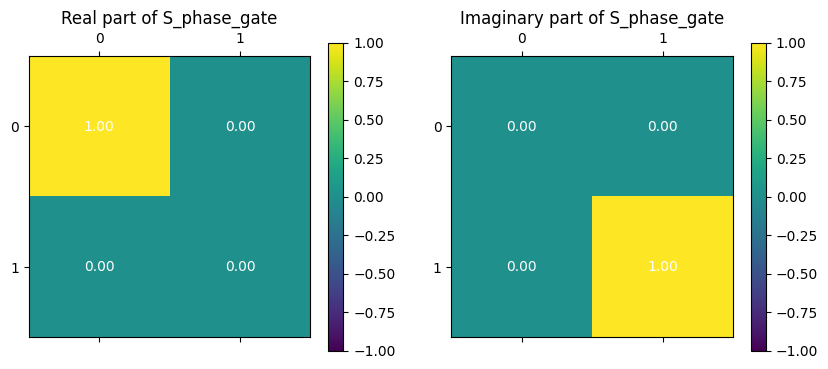

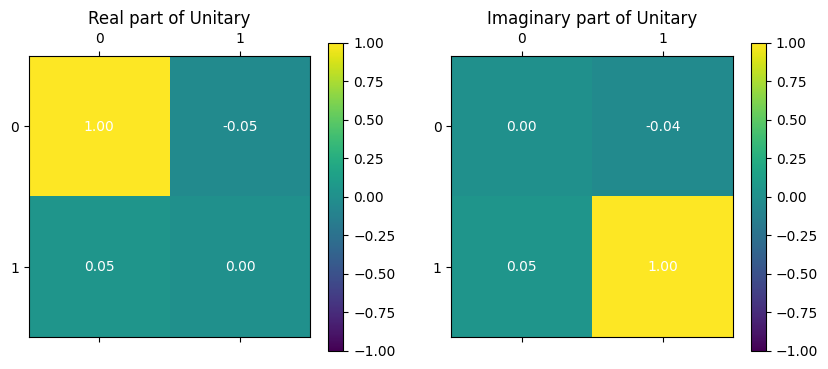

In [5]:
S_phase_gate = np.array([[1, 0], [0, 1j]])
Unitary = np.array(rotation_matrix_result_s)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(S_phase_gate, 'S_phase_gate', vmin=-1, vmax=1)
plot_matrix(Unitary, 'Unitary', vmin=-1, vmax=1)


In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_s, target_measurements_S)


Measured Probabilities for reference state 1: [0.9990234375, 0.0009765625, 0.51171875, 0.48828125, 0.5625, 0.4375]
Measured Probabilities for reference state 2: [0.00390625, 0.99609375, 0.4560546875, 0.5439453125, 0.451171875, 0.548828125]
Measured Probabilities for reference state 3: [0.4765625, 0.5234375, 0.5107421875, 0.4892578125, 0.998046875, 0.001953125]
Measured Probabilities for reference state 4: [0.5166015625, 0.4833984375, 0.48828125, 0.51171875, 0, 1.0]
Measured Probabilities for reference state 5: [0.5458984375, 0.4541015625, 0.001953125, 0.998046875, 0.5166015625, 0.4833984375]
Measured Probabilities for reference state 6: [0.4580078125, 0.5419921875, 0.9970703125, 0.0029296875, 0.509765625, 0.490234375]

Measured Probabilities Matrix:
[0.9990234375, 0.0009765625, 0.51171875, 0.48828125, 0.5625, 0.4375]
[0.00390625, 0.99609375, 0.4560546875, 0.5439453125, 0.451171875, 0.548828125]
[0.4765625, 0.5234375, 0.5107421875, 0.4892578125, 0.998046875, 0.001953125]
[0.5166015625, 

In [7]:
# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_S)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

The Target Measurements 

[[1.         0.         0.49414062 0.50585938 0.5        0.5       ]
 [0.         1.         0.50195312 0.49804688 0.51367188 0.48632812]
 [0.52929688 0.47070312 0.48046875 0.51953125 1.         0.        ]
 [0.50488281 0.49511719 0.51171875 0.48828125 0.         1.        ]
 [0.50488281 0.49511719 0.         1.         0.484375   0.515625  ]
 [0.46191406 0.53808594 1.         0.         0.50683594 0.49316406]]


The Prepared Measurements 

[[9.99023438e-01 9.76562500e-04 5.11718750e-01 4.88281250e-01 5.62500000e-01 4.37500000e-01]
 [3.90625000e-03 9.96093750e-01 4.56054688e-01 5.43945312e-01 4.51171875e-01 5.48828125e-01]
 [4.76562500e-01 5.23437500e-01 5.10742188e-01 4.89257812e-01 9.98046875e-01 1.95312500e-03]
 [5.16601562e-01 4.83398438e-01 4.88281250e-01 5.11718750e-01 0.00000000e+00 1.00000000e+00]
 [5.45898438e-01 4.54101562e-01 1.95312500e-03 9.98046875e-01 5.16601562e-01 4.83398438e-01]
 [4.58007812e-01 5.41992188e-01 9.97070312e-01 2.92968750e-03 5.

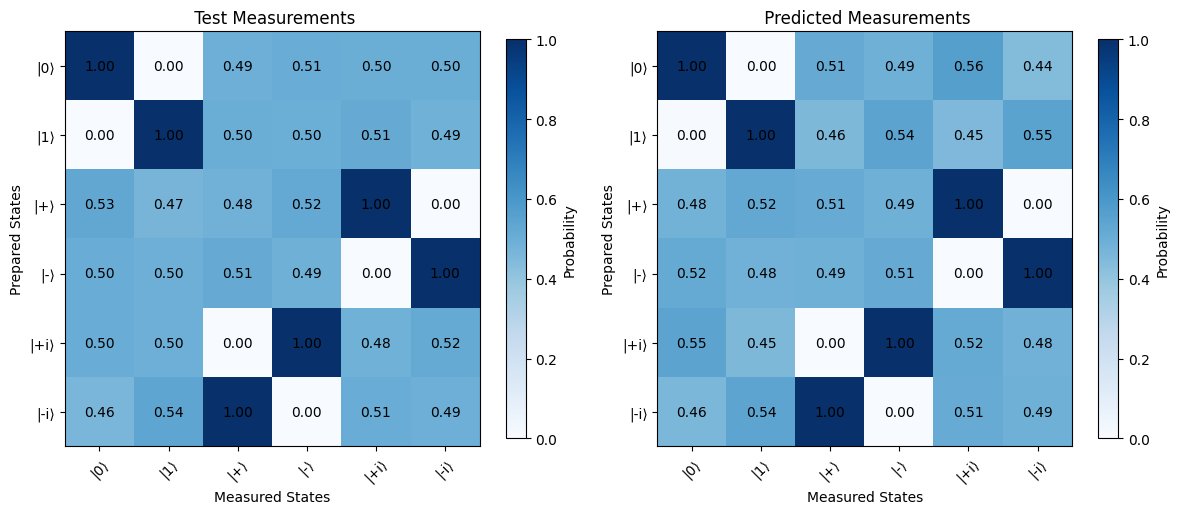

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurements')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()